# MoSDeF + HOOMD + Freud simulations of LJ particles at multiple thermodynamic states

We will be attempting to reproduce some RDFs produced by Moore et al. (2014). 
In this publication, LJ particles were simulated at a variety of thermodynamic statepoints.

![moore2014.png](./moore2014.png)

Moore, T. C.; Iacovella, C. R.; McCabe, C. Derivation of Coarse-Grained Potentials via Multistate Iterative Boltzmann Inversion. J. Chem. Phys. 2014, 140 (22).

In [1]:
import foyer
import hoomd
import mbuild as mb
import unyt as u
from mbuild.formats.gsdwriter import write_gsd
from mbuild.formats.hoomd_simulation import create_hoomd_simulation

%matplotlib inline
import freud
import gsd
import matplotlib.pyplot as plt

We will outline some basic constants to facilitate conversions to and from unitless to physical dimensions.
The foyer XML within this repo contains the same force field information.

In [2]:
# Basic constants and LJ Argon properties
sig = 0.34 * u.nm
eps = 1 * u.kilojoule
mass = 39.948 * u.amu
kb_per_mol = u.boltzmann_constant * 6.022e23
n = 2000

In [3]:
!head -n15 ff.xml

<?xml version="1.0" encoding="UTF-8"?>
<ForceField >
  <!--XML units: kJ/mol for energies, nm for lengths, and radians for angles.-->
  <AtomTypes>
    <Type name="Ar" class="Ar" element="Ar" mass="39.948" def="[Ar]" desc="LJ Argon"/>
  </AtomTypes>
  <HarmonicBondForce>
  </HarmonicBondForce>
  <HarmonicAngleForce/>
  <RBTorsionForce>
  </RBTorsionForce>
  <NonbondedForce coulomb14scale="0.0" lj14scale="0.0">
    <Atom type="Ar" charge="0" sigma="0.34" epsilon="1.00"/>
  </NonbondedForce>
</ForceField>


In [4]:
# Define various thermodynamic state points, in reduced units
statepoints = {
    "a": {"T_r": 0.5, "rho_r": 0.85},
    "b": {"T_r": 1.5, "rho_r": 0.67},
    "c": {"T_r": 2.0, "rho_r": 0.18},
}

In [5]:
# Iterate through each thermodynamic statepoint, building, parametrizing, and simulating the system
for i, statepoint in statepoints.items():
    # Create LJ particle
    lj_compound = mb.Compound(name="Ar")

    # Create mbuild Box based on reduced density
    volume = n * sig ** 3 / statepoint["rho_r"]
    cubic_box_length = volume ** (1 / 3)
    box = mb.Box([cubic_box_length, cubic_box_length, cubic_box_length])

    # Use mbuild to pack box with LJ particles
    # Use freud to wrap coordinates within box
    freud_box = freud.box.Box.from_box(box.lengths)
    filled_box = mb.fill_box(lj_compound, n_compounds=n, box=box)
    filled_box.xyz = freud_box.wrap(filled_box.xyz)

    # Apply foyer force field
    ff = foyer.Forcefield("ff.xml")
    structure = ff.apply(filled_box)

    # Dump initial coordinates
    write_gsd(structure, f"{i}_init.gsd", ref_distance=10, ref_energy=1 / 4.184)

    # Initialize hoomd simulation with relevant force field parameters
    hoomd.context.initialize("")
    snapshot, ref_vals = create_hoomd_simulation(
        structure, ref_distance=10, ref_energy=1 / 4.184
    )

    # Define hoomd group for dumping and integrating
    all_group = hoomd.group.all()

    # Dump coordinates to GSD file
    gsd_dump = hoomd.dump.gsd(f"{i}.gsd", 100, all_group, overwrite=True)

    # Define integration timestep
    hoomd.md.integrate.mode_standard(0.005)

    # Specify integrator with velocity randomization
    integrator = hoomd.md.integrate.nvt(all_group, statepoint["T_r"], 1.0)
    integrator.randomize_velocities(42)

    hoomd.run(10000)

/home/ayang41/miniconda3/envs/hoomd_lj/lib/python3.7/site-packages/foyer/forcefield.py:449: UserWarning: No force field version number found in force field XML file.
  'No force field version number found in force field XML file.'
/home/ayang41/miniconda3/envs/hoomd_lj/lib/python3.7/site-packages/foyer/forcefield.py:461: UserWarning: No force field name found in force field XML file.
  'No force field name found in force field XML file.'


HOOMD-blue 2.9.2 CUDA (10.0) DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 06/26/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
CUDA driver version is insufficient for CUDA runtime version
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 2000 particles


/home/ayang41/miniconda3/envs/hoomd_lj/lib/python3.7/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)
*Warning*: nlist: No bonds defined while trying to add topology derived 1-3 exclusions


notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
Processing LJ and QQ
notice(2): Group "charged" created containing 0 particles
No charged groups found, ignoring electrostatics
HOOMD SimulationContext updated from ParmEd Structure
** starting run **
Time 00:00:10 | Step 2049 / 10000 | TPS 204.899 | ETA 00:00:38
Time 00:00:20 | Step 4203 / 10000 | TPS 215.377 | ETA 00:00:26
Time 00:00:30 | Step 6386 / 10000 | TPS 218.239 | ETA 00:00:16
Time 00:00:40 | Step 8602 / 10000 | TPS 221.573 | ETA 00:00:06
Time 00:00:46 | Step 10000 / 10000 | TPS 223.031 | ETA 00:00:00
Average TPS: 216.104
---------
-- Neighborlist stats:
28 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 394 / n_neigh_avg: 185.739
shortest rebuild period: 5
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 243 / n_max

/home/ayang41/miniconda3/envs/hoomd_lj/lib/python3.7/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)
*Warning*: nlist: No bonds defined while trying to add topology derived 1-3 exclusions


notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
Processing LJ and QQ
notice(2): Group "charged" created containing 0 particles
No charged groups found, ignoring electrostatics
HOOMD SimulationContext updated from ParmEd Structure
** starting run **
Time 00:00:10 | Step 2295 / 10000 | TPS 229.471 | ETA 00:00:33
Time 00:00:20 | Step 4660 / 10000 | TPS 235.981 | ETA 00:00:22
Time 00:00:30 | Step 7110 / 10000 | TPS 244.921 | ETA 00:00:11
Time 00:00:40 | Step 9576 / 10000 | TPS 246.572 | ETA 00:00:01
Time 00:00:41 | Step 10000 / 10000 | TPS 238.03 | ETA 00:00:00
Average TPS: 239.179
---------
-- Neighborlist stats:
122 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 303 / n_neigh_avg: 145.869
shortest rebuild period: 6
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 65 / n_max:

/home/ayang41/miniconda3/envs/hoomd_lj/lib/python3.7/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)
*Warning*: nlist: No bonds defined while trying to add topology derived 1-3 exclusions


notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
Processing LJ and QQ
notice(2): Group "charged" created containing 0 particles
No charged groups found, ignoring electrostatics
HOOMD SimulationContext updated from ParmEd Structure
** starting run **
Time 00:00:10 | Step 7554 / 10000 | TPS 754.766 | ETA 00:00:03
Time 00:00:13 | Step 10000 / 10000 | TPS 774.173 | ETA 00:00:00
Average TPS: 759.366
---------
-- Neighborlist stats:
170 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 86 / n_neigh_avg: 39.2375
shortest rebuild period: 8
-- Cell list stats:
Dimension: 4, 4, 4
n_min    : 23 / n_max: 46 / n_avg: 31.25
** run complete **


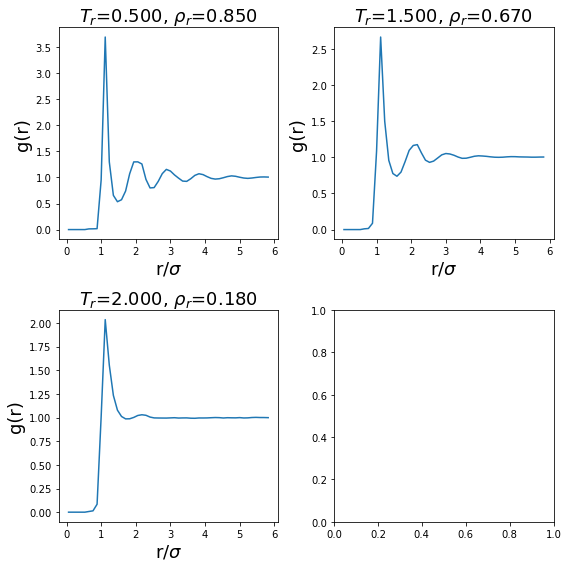

In [6]:
# Analyze the simulations by computing RDFs via freud
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, name in enumerate(statepoints):
    with gsd.hoomd.open(f"{name}.gsd", "rb") as f:
        freud_rdf = freud.density.RDF(bins=50, r_max=2, r_min=0)
        for frame in f:
            freud_rdf.compute(system=frame, reset=False)
    row = i // 2
    col = i % 2

    density = statepoints[name]["rho_r"]
    temperature = statepoints[name]["T_r"]

    ax[row, col].set_ylabel("g(r)", size=18)
    ax[row, col].set_xlabel(r"r/$\sigma$", size=18)

    ax[row, col].set_title(fr"$T_r$={temperature:.3f}, $\rho_r$={density:.3f}", size=18)
    ax[row, col].plot(freud_rdf.bin_centers / sig, freud_rdf.rdf)
    fig.tight_layout()


![moore2014.png](./moore2014.png)

Moore, T. C.; Iacovella, C. R.; McCabe, C. Derivation of Coarse-Grained Potentials via Multistate Iterative Boltzmann Inversion. J. Chem. Phys. 2014, 140 (22).